# SalesForce - REST API - Data Extract - Accounts Table

---

In [1]:
import json
import requests
import pandas as pd
import numpy as np
import seaborn as sns
from faker import Faker
from datetime import datetime

---

### # SFDC Credentials

In [2]:
security_token = os.environ.get('security_token')
sfdc_password = os.environ.get('sfdc_password')
username = os.environ.get('username')
client_id = os.environ.get('client_id')
client_secret = os.environ.get('client_secret')

---

### # Salesforce Authentication

In [3]:
# Salesforce Authentication
auth_url = 'https://login.salesforce.com/services/oauth2/token'
auth_payload = {
    'grant_type': 'password',
    'client_id': client_id,
    'client_secret': client_secret,
    'username': username,
    'password': sfdc_password + security_token
}

auth_response = requests.post(auth_url, data=auth_payload)
auth_data = auth_response.json()
access_token = auth_data['access_token']
instance_url = auth_data['instance_url']

### # Headers for API requests

In [4]:
headers = {
    'Authorization': f'Bearer {access_token}',
    'Content-Type': 'application/json'
}


### # Account table description

In [5]:
describe_url = f'{instance_url}/services/data/v52.0/sobjects/Account/describe'
describe_response = requests.get(describe_url, headers=headers)
sfdc_account_table = describe_response.json()

### # SOQL

In [6]:
sfdc_accounts_col_list = ['Id', 'Name', 'CreatedDate', 'Owner_Region__c', 'NumberOfEmployees']
sfdc_accounts_col_string = ', '.join(sfdc_accounts_col_list)
sfdc_accounts_col_query = f"SELECT {sfdc_accounts_col_string} FROM Account WHERE (NumberOfEmployees != NULL AND Owner_Region__c != NULL)"

query_url = f'{instance_url}/services/data/v52.0/query?q={sfdc_accounts_col_query}'
query_response = requests.get(query_url, headers=headers)
sfdc_accounts_data = query_response.json()

In [7]:
type(sfdc_accounts_data)

dict

In [8]:
sfdc_accounts_data

{'totalSize': 3125,
 'done': False,
 'nextRecordsUrl': '/services/data/v52.0/query/0r8xx3COBVLNo1nA4D-2000',
 'records': [{'attributes': {'type': 'Account',
    'url': '/services/data/v52.0/sobjects/Account/0015f00000Amef3AAB'},
   'Id': '0015f00000Amef3AAB',
   'Name': 'IBM',
   'CreatedDate': '2021-10-27T18:24:21.000+0000',
   'Owner_Region__c': 'AMER',
   'NumberOfEmployees': 10000},
  {'attributes': {'type': 'Account',
    'url': '/services/data/v52.0/sobjects/Account/0015f00000Amef5AAB'},
   'Id': '0015f00000Amef5AAB',
   'Name': 'Accenture',
   'CreatedDate': '2021-10-27T18:24:21.000+0000',
   'Owner_Region__c': 'AMER',
   'NumberOfEmployees': 10000},
  {'attributes': {'type': 'Account',
    'url': '/services/data/v52.0/sobjects/Account/0015f00000Amef6AAB'},
   'Id': '0015f00000Amef6AAB',
   'Name': 'SAP',
   'CreatedDate': '2021-10-27T18:24:21.000+0000',
   'Owner_Region__c': 'APAC',
   'NumberOfEmployees': 10000},
  {'attributes': {'type': 'Account',
    'url': '/services/data/

---

# SalesForce - Data Transform

In [9]:
type(sfdc_accounts_data)

dict

In [10]:
sfdc_accounts_data.keys()

dict_keys(['totalSize', 'done', 'nextRecordsUrl', 'records'])

In [11]:
sfdc_accounts_data['totalSize'] # Number of records = number of accounts in our SFDC account

3125

In [12]:
sfdc_accounts_data['records'][0]['Id']

'0015f00000Amef3AAB'

In [13]:
sfdc_accounts_data['records'][0]['CreatedDate']

'2021-10-27T18:24:21.000+0000'

In [14]:
sfdc_accounts_data['records'][0]['Owner_Region__c']

'AMER'

In [15]:
sfdc_accounts_data['records'][0]['NumberOfEmployees']

10000

## Extracting only Columns Needed

In [16]:
account_list = []

for row in sfdc_accounts_data['records']:
    
    account_Id = row['Id']
    account_Name = row['Name']
    account_CreatedDate = row['CreatedDate']
    account_Owner_Region__c = row['Owner_Region__c']
    account_NumberOfEmployees = row['NumberOfEmployees']
    extracting_date = pd.Timestamp.now()
    
    account_element = {
            'account_id': account_Id,
            'name': account_Name,
            'creation_date': account_CreatedDate,
            'owner_region': account_Owner_Region__c,
            'total_employees': account_NumberOfEmployees,
            'extracting_date': extracting_date
        }
    
    account_list.append(account_element)

## Converting it into a Pandas DataFrame

In [17]:
account_df = pd.DataFrame(account_list)

In [18]:
# For privacy I will use fake names

fake = Faker()
num_names = len(account_df)
fake_names = [fake.name() for _ in range(num_names)]
fake_names_serie = pd.Series(fake_names)
fake_names_serie

account_df['name'] = account_df.index.map(fake_names_serie)

In [19]:
account_df.head()

,account_id,name,creation_date,owner_region,total_employees,extracting_date
0,0015f00000Amef3AAB,Glenn Carpenter,2021-10-27T18:24:21.000+0000,AMER,10000,2024-07-22 17:01:33.674874
1,0015f00000Amef5AAB,Amy Coleman,2021-10-27T18:24:21.000+0000,AMER,10000,2024-07-22 17:01:33.675781
2,0015f00000Amef6AAB,David Sanders,2021-10-27T18:24:21.000+0000,APAC,10000,2024-07-22 17:01:33.675785
3,0015f00000AmfLYAAZ,Teresa Smith,2021-10-27T18:24:21.000+0000,AMER,298965,2024-07-22 17:01:33.675787
4,0015f00000AmfLbAAJ,Dr. Elizabeth Miller MD,2021-10-27T18:24:21.000+0000,APAC,301200,2024-07-22 17:01:33.675789


In [20]:
account_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   account_id       2000 non-null   object        
 1   name             2000 non-null   object        
 2   creation_date    2000 non-null   object        
 3   owner_region     2000 non-null   object        
 4   total_employees  2000 non-null   int64         
 5   extracting_date  2000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 93.9+ KB


## Duplication detected

In [21]:
account_df.select_dtypes(include='object').describe()

,account_id,name,creation_date,owner_region
count,2000,2000,2000,2000
unique,2000,1980,1154,3
top,0015f00000Amef3AAB,David Sanders,2022-05-27T17:33:55.000+0000,AMER
freq,1,3,190,814


## Counts of accounts by region

In [22]:
account_df['owner_region'].value_counts()

owner_region
AMER    814
EMEA    652
APAC    534
Name: count, dtype: int64

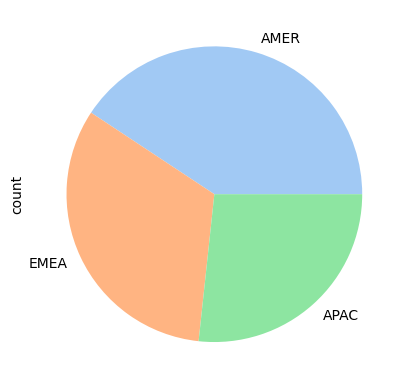

In [23]:
account_df['owner_region'].value_counts().plot(kind='pie',colors=sns.color_palette("pastel"));

## Converting string date column to date_time format

In [24]:
account_df['creation_date'] = pd.to_datetime(account_df['creation_date']).dt.strftime('%Y-%m-%d')

In [25]:
account_df['creation_date'] = pd.to_datetime(account_df['creation_date'])

In [26]:
account_df['extracting_date'] = account_df['extracting_date'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [27]:
account_df['extracting_date'] = pd.to_datetime(account_df['extracting_date'])

In [28]:
account_df.dtypes

account_id                 object
name                       object
creation_date      datetime64[ns]
owner_region               object
total_employees             int64
extracting_date    datetime64[ns]
dtype: object

# Ready to be Loaded

In [29]:
account_df # Ready for loading

,account_id,name,creation_date,owner_region,total_employees,extracting_date
0,0015f00000Amef3AAB,Glenn Carpenter,2021-10-27,AMER,10000,2024-07-22 17:01:33
1,0015f00000Amef5AAB,Amy Coleman,2021-10-27,AMER,10000,2024-07-22 17:01:33
2,0015f00000Amef6AAB,David Sanders,2021-10-27,APAC,10000,2024-07-22 17:01:33
3,0015f00000AmfLYAAZ,Teresa Smith,2021-10-27,AMER,298965,2024-07-22 17:01:33
4,0015f00000AmfLbAAJ,Dr. Elizabeth Miller MD,2021-10-27,APAC,301200,2024-07-22 17:01:33
...,...,...,...,...,...,...
1995,001AJ000002hca0YAA,William Charles,2022-08-16,APAC,10000,2024-07-22 17:01:33
1996,001AJ000002heARYAY,Richard Newton,2022-08-16,EMEA,50,2024-07-22 17:01:33
1997,001AJ000002hgIFYAY,Wesley Richards,2022-08-16,EMEA,10000,2024-07-22 17:01:33
1998,001AJ000002i2uiYAA,Kelly Thomas,2022-08-17,EMEA,500,2024-07-22 17:01:33
